### RFM-анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
orders = pd.read_csv('rfm_data.csv',sep=',')

In [3]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


In [6]:
orders.order_date=pd.to_datetime(orders.order_date)

In [8]:
last_date=orders.order_date.max()
last_date

Timestamp('2014-12-31 00:00:00')

In [19]:
rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (last_date - x.max()).days, # Recency - Количество дней с последнего заказа
                                        'order_id': 'count',      # Frequency - Количество заказов
                                        'grand_total': 'sum'}) # Monetary Value - Общая сумма по всем заказам

rfmTable.rename(columns={'order_date': 'Recency', 
                         'order_id': 'Frequency', 
                         'grand_total': 'Monetary_value'}, inplace=True)


In [20]:
rfmTable

,Recency,Frequency,Monetary_value
customer,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249
...,...,...,...
Xylona Preis,43,11,2375
Yana Sorensen,9,8,6721
Yoseph Carroll,4,5,5455


In [23]:
quantiles=rfmTable.quantile(q=[0.25,0.5,0.75]) #  у нас будет 4 сегмента пользователей

In [24]:
quantiles

,Recency,Frequency,Monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [28]:
rfmSegmentation = rfmTable
rfmSegmentation

,Recency,Frequency,Monetary_value
customer,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249
...,...,...,...
Xylona Preis,43,11,2375
Yana Sorensen,9,8,6721
Yoseph Carroll,4,5,5455


In [36]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [65]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quantiles)) 

rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FMClass, args=('Frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['Monetary_value'].apply(FMClass, args=('Monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.apply(str)+rfmSegmentation.F_Quartile.apply(str)+rfmSegmentation.M_Quartile.apply(str)

In [66]:
rfmSegmentation

,Recency,Frequency,Monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212
...,...,...,...,...,...,...,...
Xylona Preis,43,11,2375,2,1,2,212
Yana Sorensen,9,8,6721,1,2,1,121
Yoseph Carroll,4,5,5455,1,4,1,141


In [67]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,58,65,24,56
2,45,56,27,66
3,39,58,30,73
4,17,19,26,134


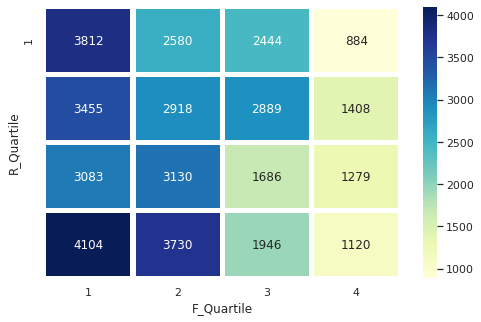

In [68]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='Monetary_value', 
                        aggfunc=np.median)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 12},yticklabels=4);

In [71]:
rfmSegmentation.RFMClass.value_counts() #большинство пользователей попадает в сегмент с наименее хорошими показателями 

444    67
443    37
344    31
144    31
111    30
       ..
412     2
134     2
331     2
424     2
114     1
Name: RFMClass, Length: 62, dtype: int64